<a href="https://colab.research.google.com/github/ankitaggarwal64/Agricultural-Equipment-Sales-Forecasting/blob/main/Univariate_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#import sales and indices combined data
combined_sales_ind = pd.read_csv("/content/drive/My Drive/1. Data Science/Sales Forecasting_Masters Project/Masters Project/Data/Output_files/combined_sales_ind.csv",parse_dates=['Time'], index_col='Time')

In [3]:
# Univariate Sales data
sales = combined_sales_ind["Sales"]

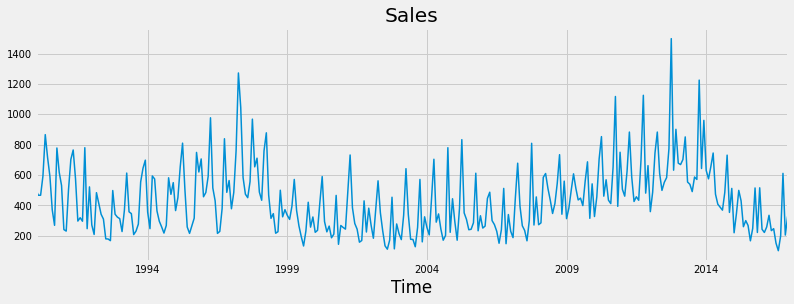

In [4]:
# Line plot of Sales time series
plt.style.use("fivethirtyeight")
ax = sales.plot(subplots= False,linewidth=1.5,sharex=False,sharey=False, figsize=(12,4),fontsize=10)
plt.title("Sales")
plt.show()

## Obseravtion : There is clear cyclicity and seasonality

In [5]:
# Train and Test Split
split_point = len(sales)-12
train,test = sales[0:split_point],sales[split_point:]
print('Train %d, Test %d' % (len(train),len(test)))

Train 312, Test 12


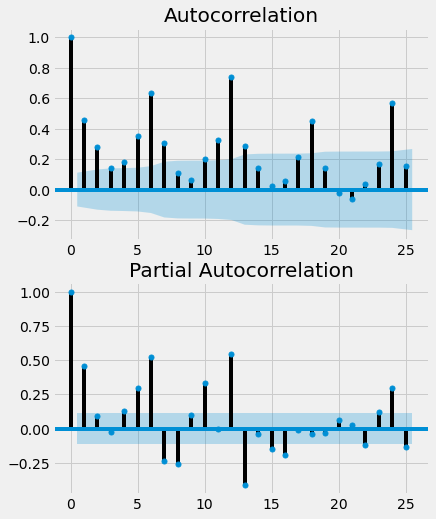

In [6]:
#Plot ACF and PACF
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import pylab
pylab.rcParams['figure.figsize'] = (6,8)
pyplot.figure()
pyplot.subplot(211)
plot_acf(train, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(train, lags=25, ax=pyplot.gca())
pyplot.show()

#OBSERVATIONS:
#There is a clear seasonality of 12 as seen in the peaks of ACF plot
#There is a possibility of both AR and MA terms because of geometric decay on ACF plot and significant autocorrelation of particular lags

In [7]:
# Define the p, d and q parameters possible values
p = range(0, 3)
d = range(0, 2)
q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# specify to ignore warning messages
warnings.filterwarnings("ignore") 

# Grid Cross validation for best parameters estimation
columns = ['param','param_seasonal','aic']
rows = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            row = [param, param_seasonal, results.aic]
            rows.append(row)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

models_aic = pd.DataFrame(rows, columns=columns)

In [9]:
models_aic.sort_values(by=["aic"])

,param,param_seasonal,aic
143,"(2, 1, 1)","(2, 1, 1, 12)",3304.336752
119,"(2, 0, 1)","(2, 1, 1, 12)",3310.965565
95,"(1, 1, 1)","(2, 1, 1, 12)",3312.941581
131,"(2, 1, 0)","(2, 1, 1, 12)",3314.708188
107,"(2, 0, 0)","(2, 1, 1, 12)",3318.700997
...,...,...,...
48,"(1, 0, 0)","(0, 0, 0, 12)",4253.463491
24,"(0, 1, 0)","(0, 0, 0, 12)",4255.832966
1,"(0, 0, 0)","(0, 0, 1, 12)",4297.589639
12,"(0, 0, 1)","(0, 0, 0, 12)",4525.151746


In [8]:
#Intantiate
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 1, 1),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# Fit training
results = mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [9]:
# Model Summary Statistics
print(results.summary())

# Obseration : High probability of Ljung-Box repesents lack of autocorrelation 

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  312
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1645.168
Date:                            Wed, 25 Nov 2020   AIC                           3304.337
Time:                                    03:47:52   BIC                           3329.603
Sample:                                01-31-1990   HQIC                          3314.479
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2741      0.104      2.646      0.008       0.071       0.477
ar.L2          0.0068      0.091   

In [45]:
# Checking Residual Summary Statistics
round(results.resid.describe()["std"],2)

# Obseration : Residual mean is near to zero.

127.53

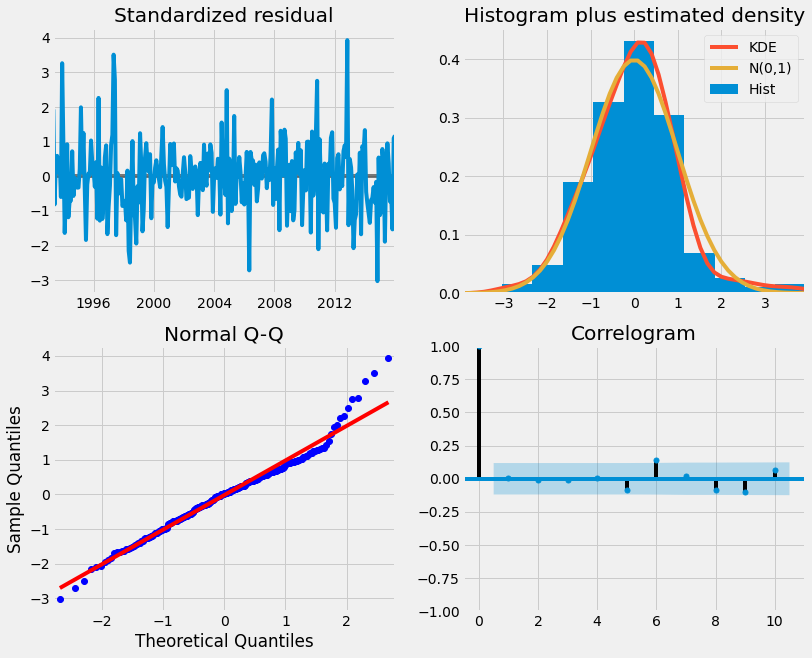

In [13]:
# Residual diagnostics
results.plot_diagnostics(figsize=(12, 10))
plt.show()

# Obervation 1: Based on plots, residuls seems to be close to white noise, normally distributed and does not seems to have any significant autocorrelation

In [17]:
# Validating Model
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [67]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Extract the predicted and true values of our time series
y_val_forecasted = pred_dynamic.predicted_mean
y_val_truth = train['2015':]

# report performance

# Compute the Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_val_truth, y_val_forecasted))
print('RMSE: %.3f' % rmse)

# Compute Bias
forecast_errors = y_val_truth - y_val_forecasted
bias = sum(forecast_errors)*1.0/len(forecast_errors)
print('Bias: %.3f' % bias)

# Compute MAPE
percent_forecast_errors = abs(y_val_truth - y_val_forecasted)*100/y_val_truth 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)
print('MAPE: %.3f' % MAPE)

#Residual Standard Deviation (Measure of Uncertanity for Prediction Interval)
Residual_stdev = results.resid.describe()["std"]
print('Residual Stdev: %.3f' % Residual_stdev)

#Avergae Prediction Interval (95%)
Avg_pred_interval = (pred_dynamic_ci["upper Sales"]- pred_dynamic_ci["lower Sales"]).mean()
print('Average Prediction Interval: %.3f' % Avg_pred_interval)

RMSE: 96.495
Bias: -44.984
MAPE: 24.435
Residual Stdev: 127.529
Average Prediction Interval: 526.796


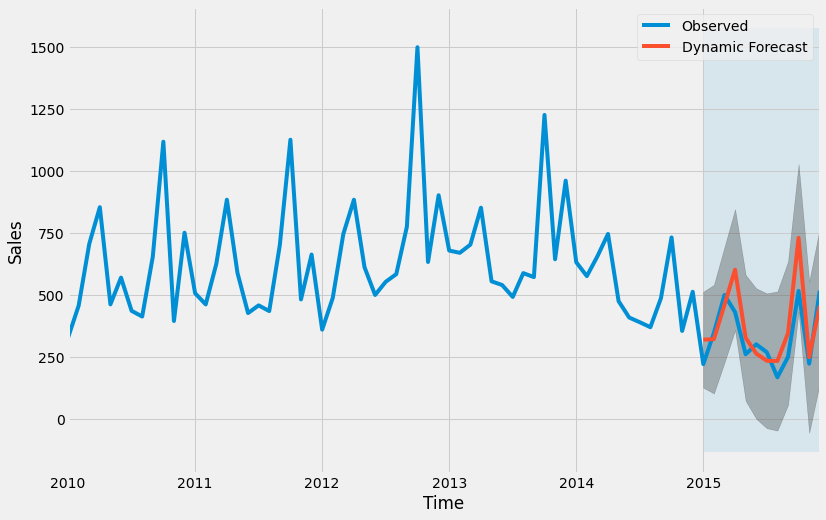

In [68]:
#Plot Model Forecast in Validation period
ax = train['2010':].plot(label='Observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-31'), train.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [69]:
# Model Testing
# Get forecast 12 steps ahead in future(2016)
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [78]:
pred_uc.conf_int()

,lower Sales,upper Sales
2016-01-31,5.799382,392.548198
2016-02-29,11.421535,449.303923
2016-03-31,148.725300,614.325536
2016-04-30,203.284091,690.676976
2016-05-31,-40.946251,466.132716
2016-06-30,-76.426931,449.272167
2016-07-31,-116.143503,427.444277
2016-08-31,-166.980857,393.898373
2016-09-30,-68.330179,509.315381
2016-10-31,268.941316,862.877904


In [80]:
# Extract the predicted and true values of our time series
y_forecasted = pred_uc.predicted_mean
y_truth = test

# report performance
# Compute the Root mean squared error
rmse = sqrt(mean_squared_error(y_truth, y_forecasted))
print('RMSE: %.3f' % rmse)

forecast_errors = y_truth-y_forecasted
bias = sum(forecast_errors)*1.0/len(forecast_errors)
print('Bias: %.3f' % bias)

percent_forecast_errors = abs(y_truth-y_forecasted)*100/y_truth 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)
print('MAPE: %.3f' % MAPE)

#Residual Standard Deviation (Measure of Uncertanity for Prediction Interval)
Residual_stdev = results.resid.describe()["std"]
print('Residual Stdev: %.3f' % Residual_stdev)

#Avergae Prediction Interval (95%)
Avg_pred_interval = (pred_ci["upper Sales"]- pred_ci["lower Sales"]).mean()
print('Average Prediction Interval: %.3f' % Avg_pred_interval)

RMSE: 60.307
Bias: -9.256
MAPE: 17.927
Residual Stdev: 127.529
Average Prediction Interval: 526.791


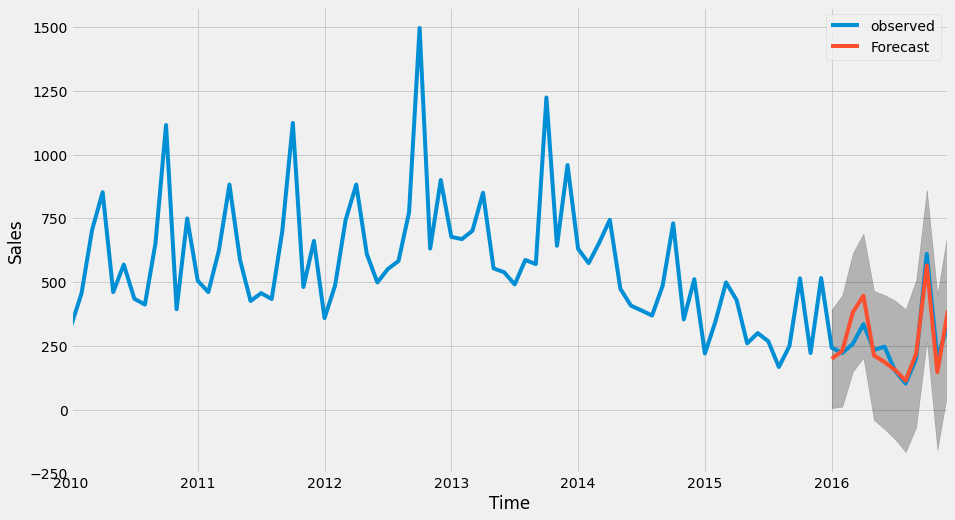

In [81]:
#Plot Model Forecast during Test Period
ax = sales['2010':].plot(label='observed', figsize=(14, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

plt.legend()
plt.show()